In [261]:
import numpy as np
import scipy.interpolate as intrplt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from pyDOE import *
import time 

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
#from cuml.gaussian_process import GaussianProcessRegressor
#from cuml.gaussian_process.kernels import RBF

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2,l1_l2
import tensorflow.keras as keras
import tensorflow as tf




from ipywidgets import interactive
import ipywidgets as widgets 




In [262]:
def f(t,a=0.1,b=-0.13,c=9):
    return np.sqrt(a)*np.exp(-b*t)*np.sin(c*t)+.5*np.cos(2*t)

def plot_with_parameters(a,b,c):
    ts= np.linspace(0,1,100)
    fs= f(ts,a,b,c)

    plt.plot(ts,fs,c='Red',label=f'f(t;{a},{b},{c})')
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.legend()
    plt.grid(True)
    plt.show()

def interactive_err(a):
    ts= np.linspace(0,1,100)
    a_s= np.linspace(0,1,10)
    fs_for_as= np.array([f(ts,a=i) for i in a_s]).T
    intrpltr= intrplt.RectBivariateSpline(ts,a_s,fs_for_as,kx=1,ky=1)
    intrpltd_fs= intrpltr(ts,a).reshape(-1)
    true_fs= f(ts,a=a)
    resid_errs= true_fs/intrpltd_fs-1
    plt.plot(ts,resid_errs,label=f'a={a}')
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.title('Ratio')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

def inter_grid(lhd,a,b):
    ts= np.linspace(0,1,100)
    fs= np.array([f(ts,a=ai,b=bi) for ai,bi in lhd]).T
    intrpltd_fs=[]
    for i,t in enumerate(ts):
        intrpltd_fs.append(intrplt.griddata(lhd,fs[i],(a,b)))

    intrpltd_fs= np.array(intrpltd_fs)

    true_fs= f(ts,a=a,b=b)
    resid_errs= true_fs/intrpltd_fs-1

    fig= plt.figure(figsize=(14,8))
    ax1= fig.add_subplot(121)
    ax1.plot(ts,intrpltd_fs, label='interpolated f(t)')
    ax1.plot(ts,true_fs,label='true f(t)')
    ax1.set(xlabel='t',ylabel='f(t)')
    ax1.grid(True)
    ax1.legend(loc='lower left')
    ax2= fig.add_subplot(122)
    ax2.plot(ts,resid_errs,label=f'a={a},b={b}')
    ax2.set(xlabel='t',ylabel='f(t)',title='Ratio')
    ax2.grid(True)
    ax2.legend(loc='lower left')
    plt.show()

def intrpltd_grid(lhd,a,b):
    ts= np.linspace(0,1,100)
    fs= np.array([f(ts,a=ai,b=bi) for ai,bi in lhd]).T
    intrpltd_fs=[]
    for i,t in enumerate(ts):
        intrpltd_fs.append(intrplt.griddata(lhd,fs[i],(a,b)))

    return np.array(intrpltd_fs)

def true_grid(a=0.1,b=-0.13,c=9.):
    ts= np.linspace(0,1,100)
    return f(ts,a=a,b=b,c=c)

def n_d_intrpltd(lhd,a,b,c):
    ts= np.linspace(0,1,100)
    fs= np.array([f(ts,a=ai,b=bi,c=ci) for ai,bi,ci in lhd]).T
    intrpltd_fs=[]
    for i,t in enumerate(ts):
        intrpltd_fs.append(intrplt.griddata(lhd,fs[i],(a,b,c)))

    return np.array(intrpltd_fs)

def n_d_inter_grid(lhd,a,b,c):
    ts= np.linspace(0,1,100)
    fs= np.array([f(ts,a=ai,b=bi,c=ci) for ai,bi,ci in lhd]).T
    intrpltd_fs=[]
    for i,t in enumerate(ts):
        intrpltd_fs.append(intrplt.griddata(lhd,fs[i],(a,b,c)))

    intrpltd_fs= np.array(intrpltd_fs)

    true_fs= f(ts,a=a,b=b,c=c)
    resid_errs= true_fs/intrpltd_fs-1

    fig= plt.figure(figsize=(14,8))
    ax1= fig.add_subplot(121)
    ax1.plot(ts,intrpltd_fs, label='interpolated f(t)')
    ax1.plot(ts,true_fs,label='true f(t)')
    ax1.set(xlabel='t',ylabel='f(t)')
    ax1.grid(True)
    ax1.legend(loc='lower left')
    ax2= fig.add_subplot(122)
    ax2.plot(ts,resid_errs,label=f'a={a},b={b},c={c}')
    ax2.set(xlabel='t',ylabel='f(t)',title='Ratio')
    ax2.grid(True)
    ax2.legend(loc='lower left')
    plt.show()


def gpr_intrpltd(gpr,a,b,c):
    #ts= np.linspace(0,1,100)
    #X_test= np.hstack((ts.reshape((-1,1)),np.vstack([[a,b,c] for _ in range(100)])))
    X_test= np.array([[a,b,c]])
    return(gpr.predict(X_test,return_std=True))

def inter_gpr(gpr,a,b,c):
    ts= np.linspace(0,1,100)
    #X_test= np.hstack((ts.reshape((-1,1)),np.vstack([[a,b,c] for _ in range(100)])))
    X_test= np.array([[a,b,c]])
    intrpltd_fs, pred_errs= gpr.predict(X_test,return_std=True)
    intrpltd_fs= intrpltd_fs.ravel()
    pred_errs= pred_errs.ravel()
    true_fs= f(ts,a=a,b=b,c=c)
    resid_errs= true_fs/intrpltd_fs-1

    fig= plt.figure(figsize=(14,8))
    ax1= fig.add_subplot(121)
    ax1.plot(ts,intrpltd_fs, label='interpolated f(t)')
    ax1.fill_between(ts,intrpltd_fs-1.96*pred_errs,intrpltd_fs+1.96*pred_errs,alpha=0.5,label='0.95 certainty')
    ax1.plot(ts,true_fs,label='true f(t)',ls='--')
    ax1.set(xlabel='t',ylabel='f(t)')
    ax1.grid(True)
    ax1.legend(loc='lower left')
    ax2= fig.add_subplot(122)
    ax2.plot(ts,resid_errs,label=f'a={a},b={b},c={c}')
    ax2.set(xlabel='t',ylabel='f(t)',title='Ratio')
    ax2.grid(True)
    ax2.legend(loc='lower left')
    plt.show()

def inter_NN(NN,a,b,c):
    ts= np.linspace(0,1,100)
    #X_test= np.hstack((ts.reshape((-1,1)),np.vstack([[a,b,c] for _ in range(100)])))
    X_test= np.array([[a,b+0.5,(c-5)/5]])
    intrpltd_fs= NN.predict(X_test,verbose=0)
    intrpltd_fs= intrpltd_fs.ravel()

    true_fs= f(ts,a=a,b=b,c=c)
    resid_errs= true_fs/intrpltd_fs-1
    fig= plt.figure(figsize=(14,8))
    ax1= fig.add_subplot(121)
    ax1.plot(ts,intrpltd_fs, label='interpolated f(t)')
    ax1.plot(ts,true_fs,label='true f(t)',ls='--')
    ax1.set(xlabel='t',ylabel='f(t)')
    ax1.grid(True)
    ax1.legend(loc='lower left')
    ax2= fig.add_subplot(122)
    ax2.plot(ts,resid_errs,label=f'a={a},b={b},c={c}')
    ax2.set(xlabel='t',ylabel='f(t)',title='Ratio')
    ax2.grid(True)
    ax2.legend(loc='lower left')
    plt.show()

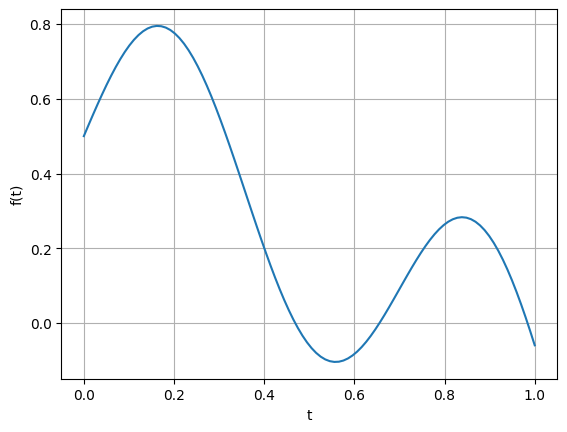

In [263]:
ts= np.linspace(0,1,100)
fs= f(ts)

plt.plot(ts,fs)
plt.ylabel('f(t)')
plt.xlabel('t')
plt.grid(True)
plt.show()

In [264]:
interactive_plot= interactive(
    plot_with_parameters,
    a=widgets.FloatSlider(min=0.,max=1.,step=0.01,value=0.1),
    b=widgets.FloatSlider(min=-0.5,max=.5,step=0.01,value=-0.13),
    c=widgets.FloatSlider(min=5,max=10,step=0.1,value=9)
)

display(interactive_plot)

interactive(children=(FloatSlider(value=0.1, description='a', max=1.0, step=0.01), FloatSlider(value=-0.13, de…

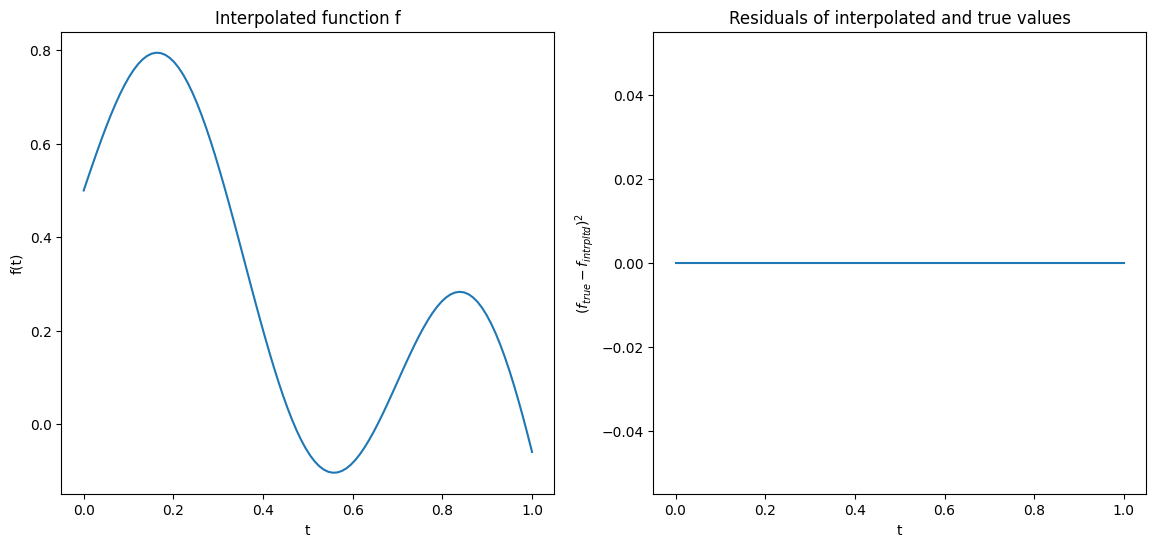

In [265]:
#Q1
#Using the original grid for interpolation

ts= np.linspace(0,1,100)
fs= f(ts)

intrpltr= intrplt.interp1d(ts,fs,kind='linear')

finer_ts= np.linspace(0,1,100)
intrpltd_fs= intrpltr(finer_ts)

true_fs= f(finer_ts)

fig= plt.figure(figsize=(14,6))

ax1= fig.add_subplot(121)
ax1.plot(finer_ts,intrpltd_fs)
ax1.set(title='Interpolated function f',ylabel='f(t)',xlabel='t')
ax2= fig.add_subplot(122)
ax2.plot(finer_ts,(true_fs/intrpltd_fs-1))
ax2.set(title='Residuals of interpolated and true values',ylabel=r"$(f_{true}-f_{intrpltd})^2$", xlabel='t')
plt.show()

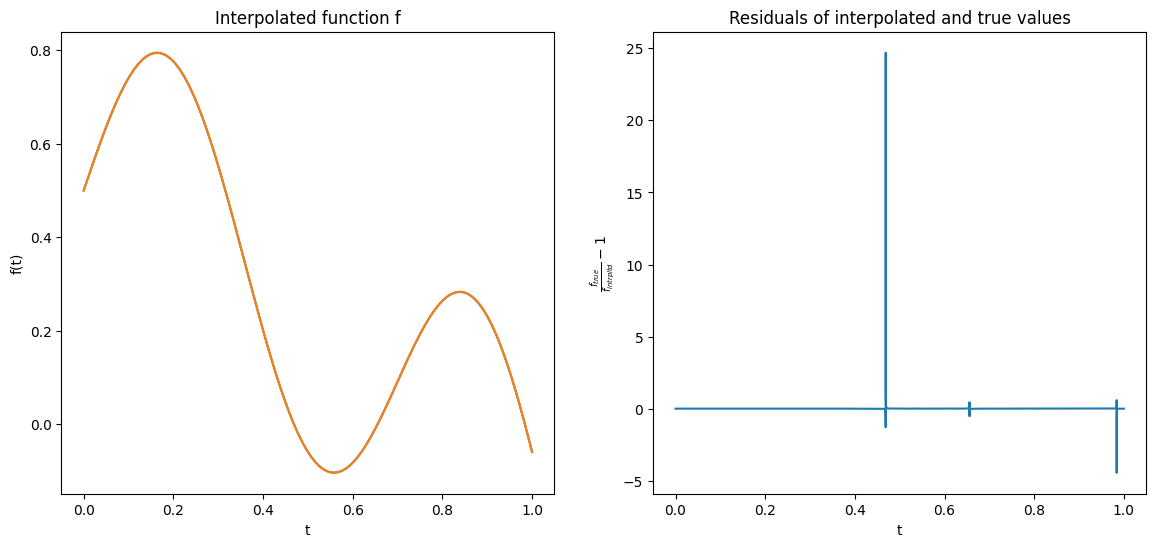

In [266]:
#Q2 and 3
#Fix all parameters except t and interpolate on a finer grid than our initial ts

ts= np.linspace(0,1,100)
fs= f(ts)

intrpltr= intrplt.interp1d(ts,fs,kind='linear')

finer_ts= np.linspace(0,1,10000)
intrpltd_fs= intrpltr(finer_ts)

true_fs= f(finer_ts)
resid_errs= true_fs/intrpltd_fs -1

fig= plt.figure(figsize=(14,6))

ax1= fig.add_subplot(121)
ax1.plot(finer_ts,intrpltd_fs)
ax1.plot(finer_ts,true_fs)
ax1.set(title='Interpolated function f',ylabel='f(t)',xlabel='t')
ax2= fig.add_subplot(122)
ax2.plot(finer_ts,resid_errs)
ax2.set(title='Residuals of interpolated and true values',ylabel=r"$\frac{f_{true}}{f_{intrpltd}}-1$", xlabel='t')
plt.show()

In [267]:
print(f"Values of f that result in a higher relative error:\
      \n{np.column_stack((finer_ts[np.argsort(resid_errs)[:10]],true_fs[np.argsort(resid_errs)[:10]]))}")

print("Clearly relative error is highest near the roots of the function")

Values of f that result in a higher relative error:      
[[ 9.83998400e-01  1.48722212e-04]
 [ 4.68746875e-01 -6.23341709e-05]
 [ 4.68646865e-01  1.65592117e-04]
 [ 6.55765577e-01  3.77820621e-05]
 [ 9.84098410e-01 -2.13607737e-04]
 [ 4.68546855e-01  3.93742442e-04]
 [ 4.68446845e-01  6.22116674e-04]
 [ 9.84198420e-01 -5.76093605e-04]
 [ 4.68346835e-01  8.50714685e-04]
 [ 4.68246825e-01  1.07953635e-03]]
Clearly relative error is highest near the roots of the function


# Q5

In [268]:
#Q5

ts= np.linspace(0,1,100)
a_s= np.linspace(0,1,10)
#Making an array of the time coordinates and the varied a coordinates
fs_for_as= np.array([f(ts,a=a) for a in a_s]).T

f_a_df= pd.DataFrame(fs_for_as)#Indexing columns Python style
f_a_df.columns= np.round(np.linspace(0,1,10),2)
f_a_df.insert(0,'t',ts)


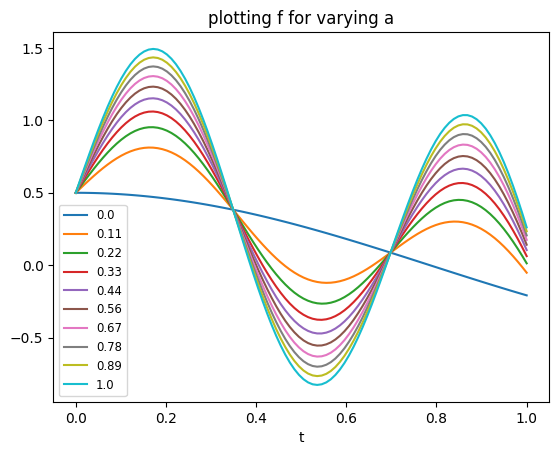

In [269]:
fig,ax= plt.subplots()
for col in f_a_df.columns[1:]:
    f_a_df.plot('t',col,ax=ax)

plt.title('plotting f for varying a')
plt.legend(loc='lower left',fontsize='small')
plt.show()

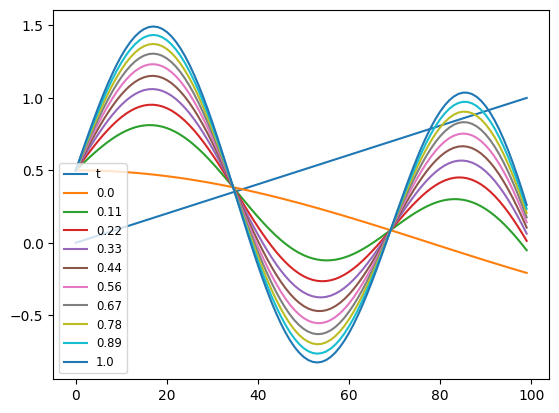

In [270]:
f_a_df.plot()
plt.legend(loc='lower left',fontsize='small')

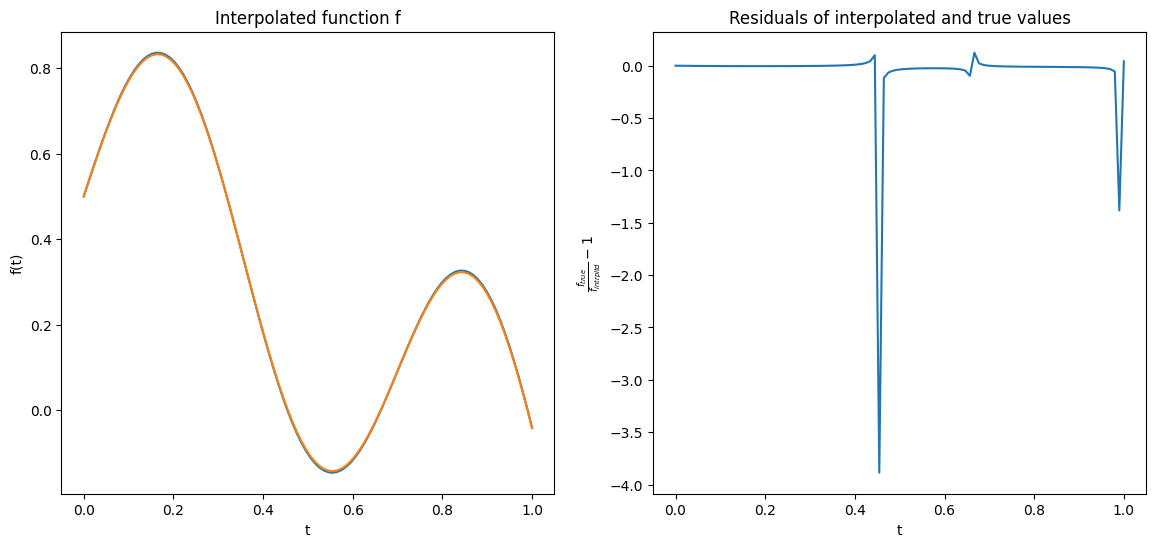

In [271]:
#Q6 interpolating over a grid
intrpltr= intrplt.RectBivariateSpline(ts,a_s,fs_for_as)
intrpltd_fs= intrpltr(ts,0.125).reshape(-1)
true_fs= f(ts,a=0.125)

resid_err= true_fs/intrpltd_fs-1

fig= plt.figure(figsize=(14,6))

ax1= fig.add_subplot(121)
ax1.plot(ts,intrpltd_fs)
ax1.plot(ts,true_fs)
ax1.set(title='Interpolated function f',ylabel='f(t)',xlabel='t')
ax2= fig.add_subplot(122)
ax2.plot(ts,resid_err)
ax2.set(title='Residuals of interpolated and true values',ylabel=r"$\frac{f_{true}}{f_{intrpltd}}-1$", xlabel='t')
plt.show()


In [272]:
#Question 7
inter_err_plot= interactive(
    interactive_err,
    a= widgets.FloatSlider(min=0,max=1,step=0.005,value=0.125)
)
display(inter_err_plot)

interactive(children=(FloatSlider(value=0.125, description='a', max=1.0, step=0.005), Output()), _dom_classes=…

### Q8
The ratio of error gets smaller as we get 'a' closer to a value that we have calculated analytically, this makes sense as we expect to get the exact analytical value more or less at those points

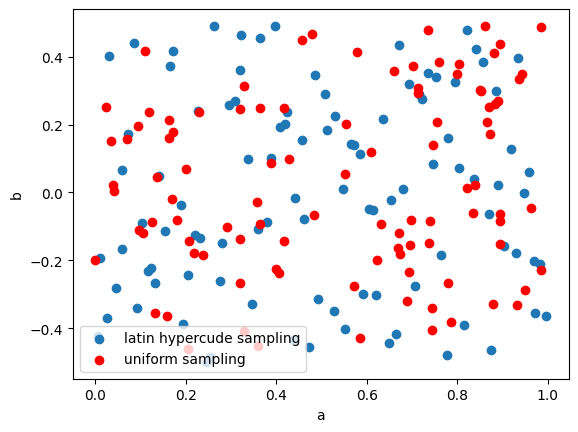

In [273]:
#Q9 and 10
lhd= lhs(2,samples=100)
lhd[:,1]-=0.5

a_s= np.random.uniform(0,1,100)
bs= np.random.uniform(-0.5,0.5,100)

plt.scatter(lhd[:,0],lhd[:,1],label='latin hypercude sampling')
plt.scatter(a_s,bs,c='Red',label='uniform sampling')
plt.xlabel('a')
plt.ylabel('b')
plt.legend()
plt.show()

LHS points are guarunteed to have only one sample at each grid point axis, while uniformly sapled points aren't spread as evenly.

To distinguish between the two, an easy check would be to see if consecutive points are equidistant from each other in each axis 

In [274]:
np.sort(lhd[:,1].round(3))

array([-0.499, -0.485, -0.478, -0.463, -0.457, -0.444, -0.434, -0.422,
       -0.418, -0.402, -0.391, -0.388, -0.37 , -0.365, -0.356, -0.348,
       -0.34 , -0.328, -0.313, -0.303, -0.299, -0.281, -0.276, -0.266,
       -0.26 , -0.244, -0.231, -0.224, -0.211, -0.203, -0.194, -0.184,
       -0.178, -0.166, -0.157, -0.149, -0.133, -0.124, -0.114, -0.109,
       -0.09 , -0.087, -0.077, -0.063, -0.053, -0.048, -0.036, -0.023,
       -0.015, -0.   ,  0.01 ,  0.011,  0.022,  0.04 ,  0.049,  0.06 ,
        0.067,  0.072,  0.085,  0.098,  0.101,  0.113,  0.129,  0.139,
        0.142,  0.153,  0.162,  0.171,  0.185,  0.192,  0.202,  0.215,
        0.225,  0.238,  0.241,  0.259,  0.269,  0.275,  0.289,  0.291,
        0.3  ,  0.318,  0.325,  0.339,  0.347,  0.353,  0.361,  0.372,
        0.386,  0.396,  0.403,  0.416,  0.423,  0.435,  0.442,  0.456,
        0.465,  0.477,  0.489,  0.491])

In [275]:
np.sort(a_s).round(3)

array([0.   , 0.023, 0.035, 0.04 , 0.042, 0.07 , 0.094, 0.098, 0.107,
       0.11 , 0.12 , 0.126, 0.133, 0.138, 0.158, 0.163, 0.163, 0.169,
       0.172, 0.181, 0.2  , 0.205, 0.207, 0.218, 0.228, 0.237, 0.291,
       0.32 , 0.321, 0.321, 0.33 , 0.33 , 0.357, 0.36 , 0.363, 0.364,
       0.388, 0.399, 0.406, 0.417, 0.418, 0.429, 0.456, 0.48 , 0.483,
       0.553, 0.554, 0.572, 0.579, 0.584, 0.609, 0.622, 0.631, 0.661,
       0.669, 0.672, 0.674, 0.69 , 0.692, 0.696, 0.698, 0.702, 0.713,
       0.713, 0.735, 0.737, 0.739, 0.744, 0.744, 0.745, 0.756, 0.759,
       0.78 , 0.787, 0.799, 0.803, 0.822, 0.835, 0.839, 0.851, 0.853,
       0.861, 0.867, 0.871, 0.872, 0.879, 0.882, 0.884, 0.89 , 0.894,
       0.894, 0.894, 0.894, 0.931, 0.936, 0.942, 0.95 , 0.963, 0.985,
       0.985])

In [276]:
#Q11 and 12
inter_grid_plot= interactive(
    inter_grid,
    lhd= widgets.fixed(lhd),
    a= widgets.FloatSlider(min=0,max=1,step=1e-10,value=lhd[0,0]),
    b= widgets.FloatSlider(min=-0.5,max=0.5,step=1e-10,value=lhd[0,1])
)

display(inter_grid_plot)

interactive(children=(FloatSlider(value=0.7068776756533329, description='a', max=1.0, step=1e-10), FloatSlider…

The error in interpolated data goes down as we get closer to grid points where the value was calculated analytically which is to be expected.

In [277]:
start_time= time.time()
for a in np.linspace(0,1,4):
    for b in np.linspace(-0.5,0.5,3):
        intrpltd_grid(lhd,a,b)
end_time= time.time()

print(f"Time taken for 12 interpolation calls: {end_time-start_time} seconds")

Time taken for 12 interpolation calls: 10.109800815582275 seconds


In [278]:
start_time= time.time()
for a in np.linspace(0,1,10):
    for b in np.linspace(-0.5,0.5,10):
        true_grid(a,b)
end_time= time.time()

print(f"Time taken for 100 true calls: {end_time-start_time} seconds")

Time taken for 100 true calls: 0.0026280879974365234 seconds


In [279]:
a= np.linspace(0,1,10)
b= np.linspace(-0.5,0.5,10)

A,B= np.meshgrid(a,b)

start_time= time.time()
intrpltd_grid(lhd,A,B)
end_time= time.time()

print(f"Time taken for 100 interpolation calls: {end_time-start_time} seconds")

Time taken for 100 interpolation calls: 0.7443399429321289 seconds


In [280]:
#Q14
lhd= lhs(3,samples=100)
lhd[:,1]-=0.5
lhd[:,2]=5*lhd[:,2]+5

In [281]:
n_d_inter_plot= interactive(
    n_d_inter_grid,
    lhd= widgets.fixed(lhd),
    a= widgets.FloatSlider(min=0,max=1,step=1e-10,value= lhd[0,0]),
    b= widgets.FloatSlider(min=-0.5,max=0.5,step=1e-10,value=lhd[0,1]),
    c= widgets.FloatSlider(min=5,max=10,step=1e-10,value=lhd[0,2])
)

display(n_d_inter_plot)

interactive(children=(FloatSlider(value=0.6095893147465583, description='a', max=1.0, step=1e-10), FloatSlider…

In [282]:
start_time= time.time()
for a in np.linspace(0,1,3):
    for b in np.linspace(-0.5,0.5,2):
        for c in np.linspace(5,10,2):
            n_d_intrpltd(lhd,a,b,c)
end_time= time.time()

print(f"Time taken for 12 interpolation calls: {end_time-start_time} seconds")

Time taken for 12 interpolation calls: 21.259120225906372 seconds


In [283]:
a= np.linspace(0,1,10)
b= np.linspace(-0.5,0.5,10)
c= np.linspace(5,10,10)

A,B,C= np.meshgrid(a,b,c)

start_time= time.time()
n_d_intrpltd(lhd,A,B,C)
end_time= time.time()

print(f"Time taken for 1000 interpolations made with one call: {end_time-start_time} seconds")

Time taken for 1000 interpolations made with one call: 1.8028230667114258 seconds


In [284]:
start_time= time.time()
for a in np.linspace(0,1,10):
    for b in np.linspace(-0.5,0.5,10):
        for c in np.linspace(5,10,10):
            true_grid(a,b,c)
end_time= time.time()

print(f"Time taken for 1000 true calls: {end_time-start_time} seconds")

Time taken for 1000 true calls: 0.02826666831970215 seconds


In [299]:
ts= np.linspace(0,1,100)
#X= lhs(3,samples=1000)
#X[:,1]-=0.5
#X[:,2]= 5*X[:,2]+5
X=lhd.copy()
Y= np.array([f(ts,a,b,c) for a,b,c in X])
X[:,1]+=0.5
X[:,2]= (X[:,2]-5)/5


X_test= lhs(3,samples=100000)
X_test[:,1]-=0.5
X_test[:,2]= 5*X_test[:,2]+5
Y_test= np.array([f(ts,a,b,c) for a,b,c in X_test])
X_test[:,1]+=0.5
X_test[:,2]= (X_test[:,2]-5)/5


model= Sequential()
model.add(Dense(100,activation='relu',kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.1))
model.add(Dense(100,activation='relu',kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.1))
model.add(Dense(100,activation='relu',kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.1))
model.add(Dense(100))

model.compile(loss=MeanSquaredError,optimizer=Adam(learning_rate=0.01))

history= model.fit(X,Y,epochs=99,verbose=1,batch_size=20,validation_data=(X_test,Y_test),validation_freq=100)


Epoch 1/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5098
Epoch 2/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2791
Epoch 3/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1921 
Epoch 4/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1596
Epoch 5/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1234
Epoch 6/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1079
Epoch 7/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0914  
Epoch 8/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0763
Epoch 9/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0740
Epoch 10/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0645
Epoch 11/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0631
Epoch 12/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0617
Epoch 13/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0559
Epoch 14/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0561
Epoch 15/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535
Epoch 16/99
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

In [298]:
inter_gpr_plot= interactive(
    inter_NN,
    NN=widgets.fixed(model),
    a= widgets.FloatSlider(min=0,max=1,step=1e-10,value=0.1),
    b= widgets.FloatSlider(min=-0.5,max=0.5,step=1e-10,value=-0.13),
    c= widgets.FloatSlider(min=5,max=10,step=1e-10,value=9)
)

display(inter_gpr_plot)

interactive(children=(FloatSlider(value=0.1, description='a', max=1.0, step=1e-10), FloatSlider(value=-0.13, d…

In [287]:
#Q15
#Making a feature set scikit learn
ts= np.linspace(0,1,100)
#lhd= lhs(3,samples=100)
#lhd[:,1]-=0.5
#lhd[:,2]= 5*lhd[:,2]+5
X= lhd.copy()
Y= np.array([f(ts,a,b,c) for a,b,c in X])


kernel= 1.*RBF(1.)
gpr= GaussianProcessRegressor(kernel=kernel)
gpr.fit(X,Y)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1))

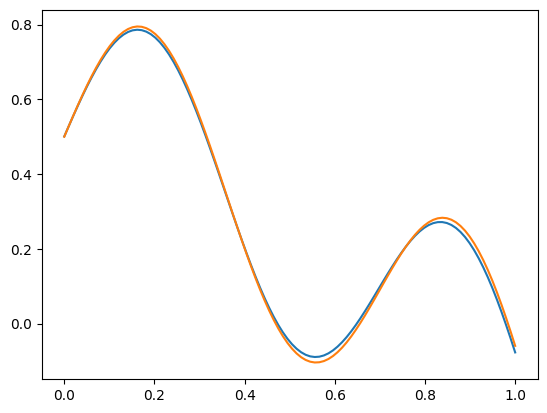

In [288]:
ts=np.linspace(0,1,100)
intrpltd_fs,errs=gpr_intrpltd(gpr,0.1,-0.13,9)
true_fs= f(ts,0.1,-0.13,9)

plt.plot(ts,intrpltd_fs.ravel())
plt.plot(ts,true_fs)

In [289]:
inter_gpr_plot= interactive(
    inter_gpr,
    gpr=widgets.fixed(gpr),
    a= widgets.FloatSlider(min=0,max=1,step=1e-10,value=lhd[0,0]),
    b= widgets.FloatSlider(min=-0.5,max=0.5,step=1e-10,value=lhd[0,1]),
    c= widgets.FloatSlider(min=5,max=10,step=1e-10,value=lhd[0,2])
)

display(inter_gpr_plot)

interactive(children=(FloatSlider(value=0.6095893147465583, description='a', max=1.0, step=1e-10), FloatSlider…